## TF-IDF: Feature Extraction of Gene Ontology (GO) Definitions for Prediction Tasks

The Gene Ontology (GO) is a directed knowledge graph where **each node is a GO term** defining a particular aspect of genes and their products. The GO terms (nodes) are categoryzed into three major ontologies:

- <font color="grey">***Molecular Function (MF)***</font>: specify the **activity** performed by the gene product, which can be "catalysis", "transport", etc. These functions can be narrowed down by more specific GO terms. "protein kinase activity" is more specific than just "catalysis"

- <font color="grey">***Cellular Component (CC)***</font>: specify the subcellular **location** of the gene product, which includes compartments (e.g. 'chloroplast', 'nucleus') or macromolecular complexes such as the 'proteasome' or 'ribosome'.

- <font color="grey">***Biological Process (BP)***</font>: specify the biological **pathway** in which the gene product is involved. Examples are 'DNA repair', 'carbohydrate metabolic process', or more general processes such as 'byosynthetic process'.

Actually, the GO graph is an amalgamation of these three aspects of gene annotation. The terms are organized **hierarchically** and **interconnected by edges representing their relationships**. Thus, the GO graph can be seen that as three independent trees (MF, CC and BP). As a directed graph, we define *parent* and *child* terms according to the *generations* they belong in the tree: terms closer to the root are parents and those closer to the terminal leaves are child terms.

We can use the GO graph to classify genes and proteins regarding their functions, processes in which they are involved and the subcellular location. The GO graph is an essential tool to predict functions of newly discovered genes.

In this notebook, we will extract features from GO term definitions using Term Frequency - Inverse Document Frequency (TF-IDF) for machine learning tasks. TF-IDF is an important measure in NLP and can be calculated in a variety of ways depending on the application (checkout the [Sklearn's guide for text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) to know the math behind it). In TF-IDF, the occurrence frequency of each token is a **feature**, and the vector with all frequencies in a document is a **multivariate sample** that can be used in machine learning tasks such as to predict labels or rank documents using similarity measures (e.g. [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)).

>**Feature Extraction**: Machine learning algorithms are quite narrow about their 'understanding': they accept **only numbers**. Any other type of data have to be converted into numbers to be fed into any data-crunching pipeline. To use texts as input into machine learning models, we need to extract numerical features in such a way that they represent the text from which they were generated. We can do this by analyzing the frequencies of terms in a **corpus** composed of **documents** (here, each GO term text definition is a *document*). It is important to note that only term frequencies are considered and not the context they appear in the sentence. To extract features from text documents considering the order and relationships of terms in the document, we need to **embed** these documents in a feature vector using, for example, **Transformer** architectures such as [Bidirectional Encoder Representations from Transformers (BERT)](https://huggingface.co/docs/transformers/model_doc/bert). 



As an example, we will use the TF-IDF to classify sentences from publications in Molecular Biology regarding the GO major ontologies (or *aspects*).

In [ ]:
# install required libraries

# !pip install obonet
# !pip install wordcloud

In [1]:
# import libraries

import re
import random
import pickle
from joblib import dump, load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from obonet import read_obo
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud
from tqdm.notebook import tqdm_notebook

# progress bar for loops
tqdm_notebook.pandas()

# set home directory
from pathlib import Path

home_dir = Path("../GO-graph-embed/")
print(f"Home directory: {home_dir.as_posix()}")

# download / update punkt, the nltk's recommended sentences' tokenizer
import nltk

nltk.download("punkt")

# custom functions

# plot confusion matrix
def plot_cm(y_true: pd.Series, y_pred: pd.Series):
    # print out the balanced accuracy score
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_pred, y_true):.1%}")

    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize="pred",
    )

    # converting into dataframe for easy plotting
    cm_df = pd.DataFrame(
        cm,
        index=["Biological Process", "Cellular Component", "Molecular Function"],
        columns=["Biological Process", "Cellular Component", "Molecular Function"],
    )

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(
        data=cm_df,
        annot=True,
        cmap="Blues",
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

Home directory: ../GO-graph-embed


[nltk_data] Downloading package punkt to /home/clever/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading and Parsing GO Graph Data

The GO graph is stored in the *OBO format*, which is specifically tailored for constructing and representing biological ontologies. To read and parse the GO graph, we utilize the Python library *obonet*, which allows us to convert it into a NetworkX object. This object provides a comprehensive toolkit for graph manipulation and analysis.

First things first, let's load the GO graph file and check some attributes:

In [2]:
go_graph = read_obo(home_dir.joinpath("data/go-basic.obo"))

print(f"The GO graph is a {go_graph}.")
print(f"Is Directed Acyclic Graph (DAG)?: {nx.is_directed_acyclic_graph(go_graph)}")
print(f"Is MultiGraph (multiple edges between two nodes)?: {go_graph.is_multigraph()}")
print(f"Is weighted graph?: {nx.is_weighted(go_graph)}")

The GO graph is a MultiDiGraph named 'go' with 43248 nodes and 84805 edges.
Is Directed Acyclic Graph (DAG)?: True
Is MultiGraph (multiple edges between two nodes)?: True
Is weighted graph?: False


The nodes of the GO graph contain attributes with essential information about each term. To get a glimpse of this data, let's print out the attributes of a randomly selected node:

In [3]:
go_graph.nodes()[random.choice([x for x in go_graph.nodes()])]

{'name': 'prevention of polyspermy during double fertilization',
 'namespace': 'biological_process',
 'def': '"The regulation of double fertilization forming a zygote and endosperm process that ensures that only a single sperm cell fertilizes one egg cell and another single sperm cell fertilizes one central cell." [PMID:27951463]',
 'is_a': ['GO:0080155']}

All GO terms contain the following essential attributes:

>***name***: unique identifier of the term in a human-readable format

>***namespace***: one of the three major ontologies (MF, CC or BP) to which the term belongs

>***definition***: short description of what the GO term means for humans. It can also contains references to publications defining the term (e.g. PMID:10873824).

There are additional attributes of each node corresponding to GO terms, but we won't be using them in this project.

### Converting the GO terms attributes into a Pandas Dataframe

We will extract the attributes from GO graph nodes into a dataframe to facilitate the processing of the text definitions. We will also add a column with the length of the text definition of each GO term. This will help us to determine the parameters when deploying **pre-trained Large Language Models (LLMs)** to extract features from GO terms' definitions and embed them into a feature vector.

In [ ]:
# create GO definitions dataframe

# empty dataframe
go_df = pd.DataFrame(columns=["go_id", "name", "aspect", "definition", "def_length"])

for idx, item in tqdm_notebook(
    enumerate(go_graph.nodes.items()), total=len(go_graph.nodes)
):
    go_term = item[0]
    name = item[1]["name"]
    aspect = item[1]["namespace"]
    definition = item[1]["def"].split(sep='"', maxsplit=2)[1]
    length = len(definition)
    go_df.loc[idx] = [
        go_term,
        name,
        aspect,
        definition,
        length,
    ]

# saving dataframe
home_dir.joinpath("data/").mkdir(parents=True, exist_ok=True)
go_df.to_csv(home_dir.joinpath("data/go_df.csv"), index=False)

go_df

We can use the Pandas' method `Dataframe.describe()` to check the mean, max and min lengths of GO terms' definitions (the method considers only *numeric* columns...):

In [4]:
go_df = pd.read_csv(home_dir.joinpath("data/go_df.csv"))

print(f"GO entries: {go_df.shape[0]}, features: {go_df.shape[1]}")
display(go_df.head())

GO entries: 43248, features: 5


,go_id,name,aspect,definition,def_length
0,GO:0000001,mitochondrion inheritance,biological_process,"The distribution of mitochondria, including th...",183
1,GO:0000002,mitochondrial genome maintenance,biological_process,The maintenance of the structure and integrity...,145
2,GO:0000003,reproduction,biological_process,The production of new individuals that contain...,124
3,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,Enables the transfer of zinc ions (Zn2+) from ...,248
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,Enables the transfer of a solute or solutes fr...,285


We can also visually inspect the length (the **number of characters** in this case...) distribution of GO terms text definitions. The [`seaborn.histplot()`](https://seaborn.pydata.org/generated/seaborn.histplot.html) function can plot the *kernel density distribution* (*KDE*) to estimate the text length distribution:

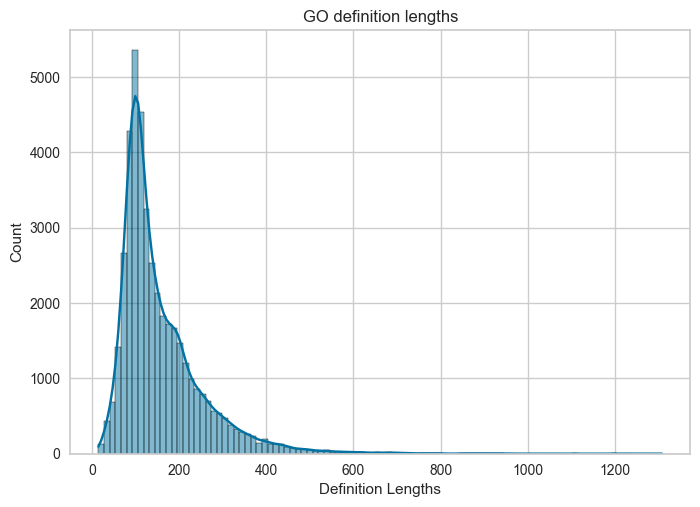

In [5]:
go_hist = sns.histplot(go_df["def_length"].values, bins=100, kde=True)
go_hist.set_title("GO definition lengths")
go_hist.set_xlabel("Definition Lengths")

plt.show()

By plotting the length of the GO terms definitions and analyzing the quartiles, we can see that most definitions fall bellow 200 words (75%), with mean length of ~150 words.

### Feature Extraction

We can obtain the TF-IDF from GO term definitions using Sklearn's [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). TfidVectorizer **tokenizes** the text (split into words using white-spaces or punctuations), attribute an *id* to each one, and provide a normalized count of the occurrence of each term considering the frequency in each document (TF) as well as in all documents in the *corpus* (IDF). The normalization is key to identify the relative importance of each token regarding its relative frequency in the document and the corpus. The most useful tokens for machine learning applications are those with higher frequency in a specific document and low frequency among all documents in the corpus, i.e., they have more *discrimination* power for similarity measures.

We set the vectorizer to remove commonly frequent words (***stop words***) such as 'the', 'are', 'is', etc. However, these words can be important for classification. Later, we will evaluate if by removing such words we are also removing meaningful information from GO terms' definitions. Another **preprocessing** step is to strip accents and convert the text to lowercase. We expect to retain only what is essential in the text to give meaning to it. We also use a **regular expression** (`token_pattern` parameter in `TfidfVectorizer()`) to keep only words composed of alphanumeric characters (excluding isolated numbers but keeping words such as h2o, co2, o2, etc...).

>TF-IDF is a **Bag of Words** representation and does not take in consideration the sequence of words in the text but only the frequency. The text [transformers]() that we will be use for feature extraction process sequences, i.e., the order of the terms matters when extracting features.

In [6]:
# set token pattern for tf-idf vectorizer
token_pattern = r"\b(?![A-Za-z]\b)(?:[A-Za-z]+\d*\d*[A-Za-z]*\d*[A-Za-z]+|[A-Za-z]+)\b"

In [7]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    strip_accents="unicode",
    lowercase=True,
    token_pattern=token_pattern,
)

go_to_tfidf = vectorizer.fit_transform(go_df.definition.values)
go_to_tfidf

<43248x19525 sparse matrix of type '<class 'numpy.float64'>'
	with 520489 stored elements in Compressed Sparse Row format>

`TfidfVectorizer` learns the **vocabulary** and returns a **sparse matrix** tipical of TF-IDF because of the small subset of words in the *corpus*. The matrix is stored in **Compressed Sparse Row (CSR)** format, which is more efficient for computations. The vocabulary is a dictionary containing the mapping (indices) of the words in the corpus in the format {'distribution': 5304 'mitochondria': 11351, 'including': 9032, 'mitochondrial': 11352, ...}.

We can also visualize a bar plot with the count of the most frequent tokens using the handy YellowBrick Python library:

Number of tokens: 19525


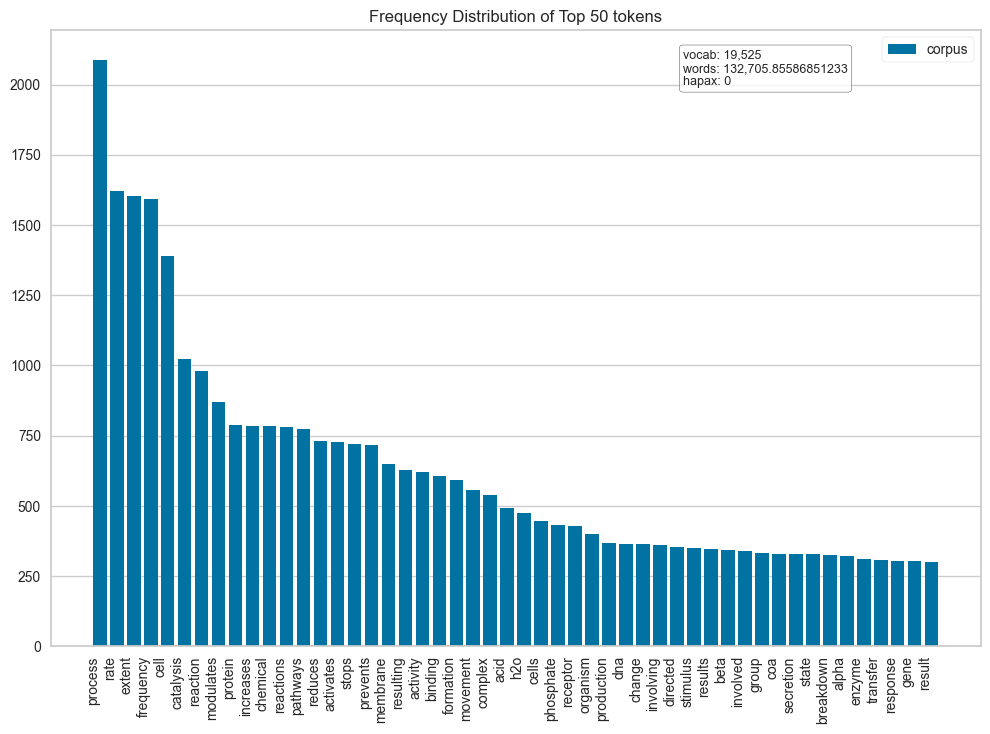

In [8]:
features = vectorizer.get_feature_names_out()
print(f"Number of tokens: {len(features)}")

# adjust figure size
plt.figure(figsize=(12, 8))

visualizer = FreqDistVisualizer(features=features, orient="v", n=50)
visualizer.fit(go_to_tfidf).show()
plt.show()

A nice way to visualize the most frequent words in the *corpus* is by plotting them into an [word cloud](https://pypi.org/project/wordcloud/), where the frequency of words is plotted with correlate font sizes. We will be plotting the word cloud including the preprocessed definitions of the full GO graph and for each major ontology (CC, MF and BP) separatelly:

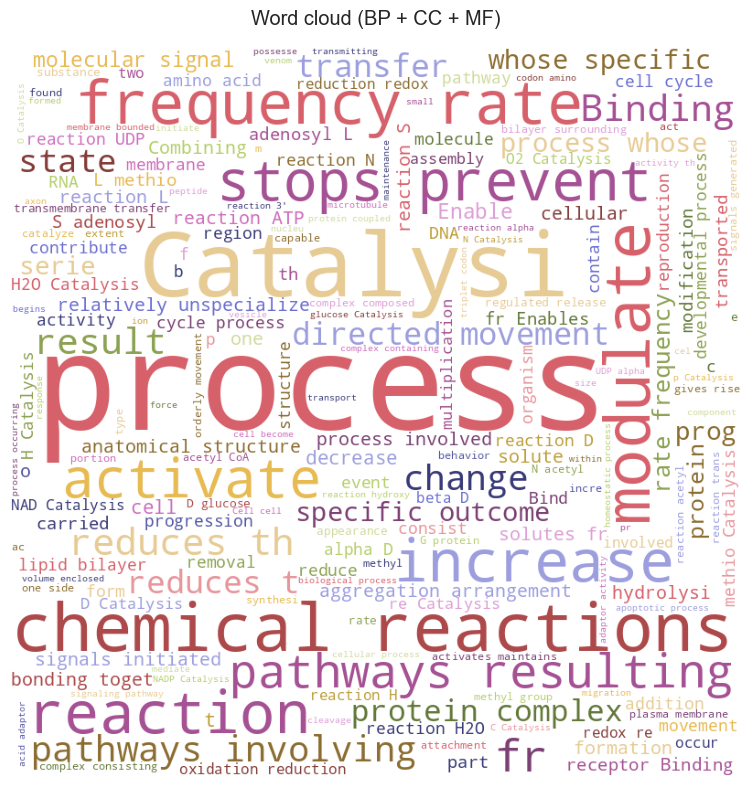

In [9]:
go_wordcloud = WordCloud(
    width=800, height=800, background_color="white", min_font_size=10, colormap="tab20b",
).generate(go_df.definition.to_string())

plt.figure(figsize=(8, 8), facecolor=None)
plt.suptitle("Word cloud (BP + CC + MF)")
plt.imshow(go_wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()

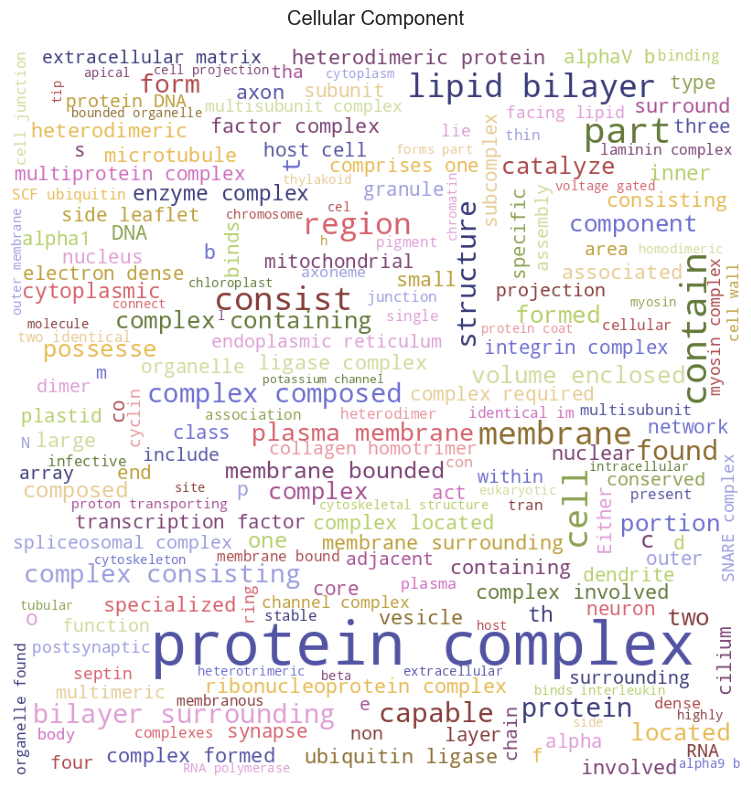

In [10]:
go_cc_wordcloud = WordCloud(
    width=800, height=800, background_color="white", min_font_size=10, colormap="tab20b"
).generate(go_df[go_df.aspect == "cellular_component"].definition.to_string())

plt.figure(figsize=(8, 8), facecolor=None)
plt.suptitle("Cellular Component")
plt.imshow(go_cc_wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()

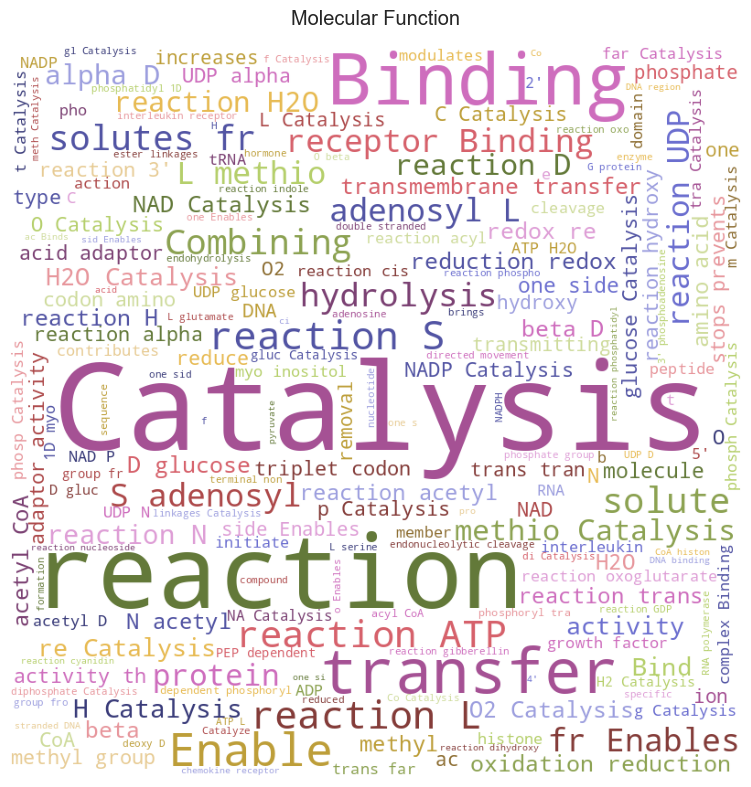

In [11]:
go_mf_wordcloud = WordCloud(
    width=800, height=800, background_color="white", min_font_size=10, colormap="tab20b"
).generate(go_df[go_df.aspect == "molecular_function"].definition.to_string())

plt.figure(figsize=(8, 8), facecolor=None)
plt.suptitle("Molecular Function")
plt.imshow(go_mf_wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()

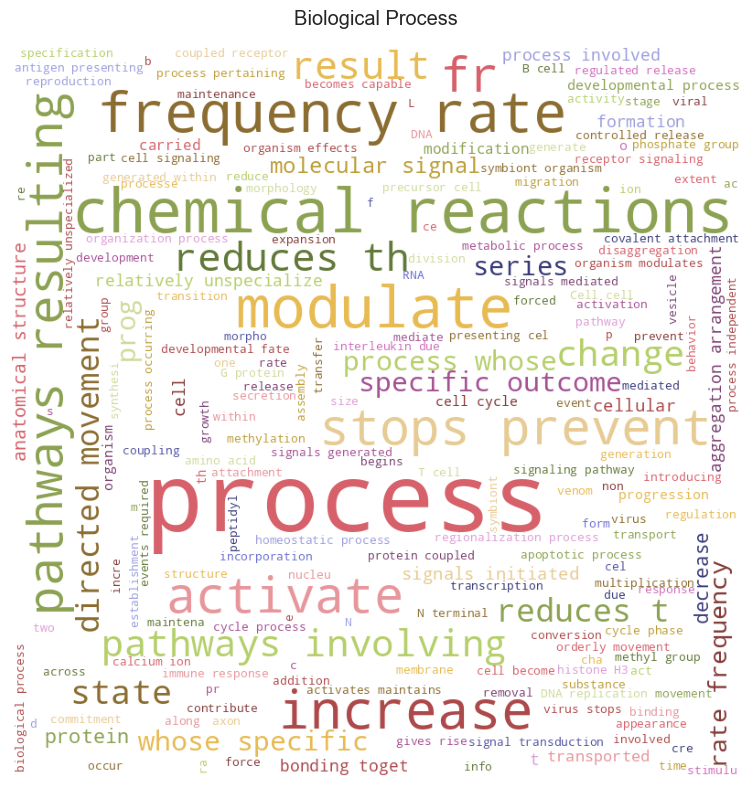

In [12]:
go_bp_wordcloud = WordCloud(
    width=800, height=800, background_color="white", min_font_size=10, colormap="tab20b"
).generate(go_df[go_df.aspect == "biological_process"].definition.to_string())

plt.figure(figsize=(8, 8), facecolor=None)
plt.suptitle("Biological Process")
plt.imshow(go_bp_wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()

For the next steps of this tutorial, we split the dataset into train, validation and test sets and take a look in the datasets. We use stratification to equally distribute the aspects among the datasets:

In [13]:
# split test
df_train_val, df_test = train_test_split(
    go_df, test_size=0.2, random_state=42, stratify=go_df.aspect
)

# split validation
df_train, df_val = train_test_split(
    df_train_val, test_size=0.2, random_state=43, stratify=df_train_val.aspect
)
print("Dataset shape:")
print(f"Train: {df_train.shape}")
print(f"Validation: {df_val.shape}")
print(f"Test: {df_test.shape}")

# check if classes are equally distributed (bp + mf + cc = 1)
print("\nTrain:")
print(df_train.aspect.value_counts() / df_train.aspect.value_counts().sum())
print("\nValidation:")
print(df_val.aspect.value_counts() / df_val.aspect.value_counts().sum())
print("\nTest:")
print(df_test.aspect.value_counts() / df_test.aspect.value_counts().sum())

Dataset shape:
Train: (27678, 5)
Validation: (6920, 5)
Test: (8650, 5)

Train:
biological_process    0.646073
molecular_function    0.260423
cellular_component    0.093504
Name: aspect, dtype: float64

Validation:
biological_process    0.646098
molecular_function    0.260405
cellular_component    0.093497
Name: aspect, dtype: float64

Test:
biological_process    0.646127
molecular_function    0.260462
cellular_component    0.093410
Name: aspect, dtype: float64


It is always good to take a look on the data:

In [14]:
display(df_train.head())
display(df_val.head())
display(df_test.head())

,go_id,name,aspect,definition,def_length
8195,GO:0015410,ABC-type manganese transporter activity,molecular_function,Enables the transfer of a solute or solutes fr...,163
9017,GO:0016540,protein autoprocessing,biological_process,Processing which a protein carries out itself....,154
24241,GO:0050657,nucleic acid transport,biological_process,"The directed movement of nucleic acids, single...",259
19679,GO:0044179,hemolysis in another organism,biological_process,"The cytolytic destruction of red blood cells, ...",119
20546,GO:0045485,omega-6 fatty acid desaturase activity,molecular_function,Catalysis of the introduction of an omega-6 do...,94


,go_id,name,aspect,definition,def_length
32596,GO:0098747,"slow, calcium ion-dependent exocytosis of neur...",biological_process,"The slow, second phase of calcium ion-induced ...",339
8651,GO:0016007,mitochondrial derivative,cellular_component,The major and minor mitochondrial derivatives ...,158
5333,GO:0008207,C21-steroid hormone metabolic process,biological_process,The chemical reactions and pathways involving ...,135
19891,GO:0044488,modulation of voltage-gated sodium channel act...,biological_process,Any process in which an organism effects a cha...,153
34057,GO:0103015,4-amino-4-deoxy-L-arabinose transferase activity,molecular_function,Catalysis of the reaction: (Kdo)2-lipid A + 2 ...,204


,go_id,name,aspect,definition,def_length
5417,GO:0008312,7S RNA binding,molecular_function,"Binding to a 7S RNA, the RNA component of the ...",80
3855,GO:0005905,clathrin-coated pit,cellular_component,A part of the endomembrane system in the form ...,414
31959,GO:0097336,response to risperidone,biological_process,Any process that results in a change in state ...,197
9863,GO:0018544,4-carboxy-4'-sulfoazobenzene reductase activity,molecular_function,Catalysis of the reaction: 4-carboxy-4'-sulfoa...,114
32214,GO:0097611,dinoflagellate cingulum,cellular_component,A cell surface furrow that wraps around a dino...,99


## Using TF-IDF to Predict GO Major Ontologies (BP, MF, CC)

We can use TF-IDF to **rank the documents** according to the similarity to a query or to use these features in **machine learning classification tasks**. Here we use tradicional learning algorithms to predict the major ontology of a GO term based on its definition. We can apply the TfidVectorizer for each dataset. The *token_pattern* parameter indicates the pattern to match in order to obtain only meaningful tokens. It uses **regex** code to match patterns in a text string. More information about the vast world of possible **regular expressions** visit [Python's regex introduction tutorial](https://docs.python.org/3/howto/regex.html#regex-howto) and [Regular-Expressions.info](https://www.regular-expressions.info/quickstart.html) for more advanced regex code.

In [15]:
# config vectorizer
# the token pattern excludes numeric characters that are not part of a word
vectorizer = TfidfVectorizer(
    stop_words="english",
    strip_accents="unicode",
    lowercase=True,
    token_pattern=token_pattern,
)

# train
X = vectorizer.fit_transform(df_train.definition)
tokens = vectorizer.get_feature_names_out()

# tf-idf dataframe (rows: tf-idf, columns: features (tokens))
x_train = pd.DataFrame(
    data=X.toarray(),
    columns=tokens,
)

y_train = df_train.aspect

# validation
X = vectorizer.transform(df_val.definition)
tokens = vectorizer.get_feature_names_out()

x_val = pd.DataFrame(
    data=X.toarray(),
    columns=tokens,
)

y_val = df_val.aspect

# test
X = vectorizer.transform(df_test.definition)

tokens = vectorizer.get_feature_names_out()

x_test = pd.DataFrame(
    data=X.toarray(),
    columns=tokens,
)

y_test = df_test.aspect

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_train: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_train: {y_test.shape}")

x_train: (27678, 16577), y_train: (27678,)
x_val: (6920, 16577), y_train: (6920,)
x_test: (8650, 16577), y_train: (8650,)


We can see that the datasets present a large number of features, which can be a problem in fitting any model in reasonable time. Moreover, there are features that are more relevant for classification tasks.

Improving performance of machine learning models also includes selecting the **most informative features**, i.e., those bearing more variance among the documents in the corpus. Tokens that are frequent in all documents of the corpus has little discrimation power, while tokens with many ocurrences in just a few documents are more relevant for ranking or classification tasks.  Irrelevant features can diminishes model's performance and increase fitting and prediction computation time.

We will try to fit the data and predict the major GO ontology using out-of-the-box classification algorithms from [Sklearn](https://scikit-learn.org/stable/supervised_learning.html).

[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), or **logit**, is a fast classification algorithm that have plenty of **hyperparameters** to tune the model and achieve better performance. I am increasing the number of iterations from 100 to 300 to ensure model's convergence.

>To check the running time of a cell you can add `%%time` in the first line of the cell.

An important thing to do before training our models is to **scale** the data. However, it is not recommended in the case of such datasets with categorical values (TF-IDF is a case) because it is not natural (occurrences are integer counts and not real numbers). Anyways, by scalling we move the data to the center of the distribution but in practice we ignore the [shape of the distribution](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler). Standardized data is required for most algorithms (such as Support Vector Machine Classifier and Logistic Regression) to improve convergence time and model's performance but in our case the recommendation is left the data as it is...

Below we instantiate the Logistic Regression classifier from Sklearn and use the custom function `plot_cm()` defined above to plot the[ confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and take a look on the model's performance in predicting each class. The [balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) is the indicated metric because we know that the dataset is imbalanced: 

Balanced Accuracy Score: 96.5%


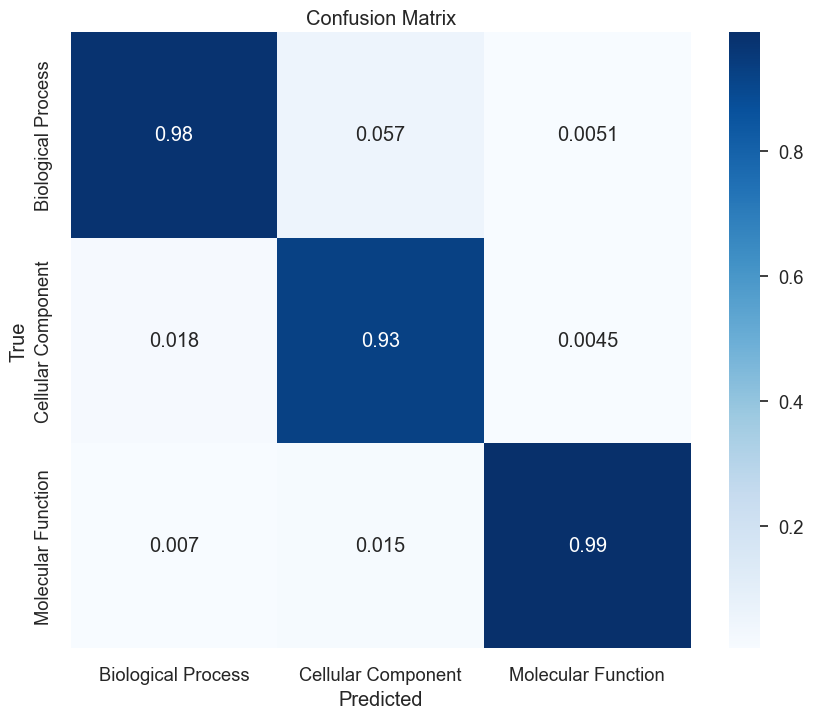

CPU times: user 2min 9s, sys: 9.01 s, total: 2min 18s
Wall time: 18.1 s


In [16]:
%%time

# implement logit
clf_lr = LogisticRegression(random_state=42, max_iter=300)

# fit data
clf_lr.fit(x_train, y_train)

# plot confusion matrix and balanced accuracy score (validation set)
plot_cm(y_val, clf_lr.predict(x_val))

Logistic Regression training is relativelly fast even with the large number of features. However, we can find difficulties when dealing with other algorithm. Let's train the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with all TF-IDF features and check the fitting and prediction elapsed time. The routine of most Sklearn algorithms is mostly the same: instantiate a classifier class (one can also *tweak the algorithm hyperparameters*), fit the training data and validate using data never seen by the model during training:

In [ ]:
%%time

clf_rf = RandomForestClassifier(random_state=42)

clf_rf.fit(x_train, y_train)

plot_cm(y_val, clf_rf.predict(x_val))

**Dimensionality reduction** techquiques can be useful to select only the features with most of the variance in the dataset. Let's apply the truncated Singular Value Decomposition `TruncatedSVD`, which can be efficiently applied to sparse matrices such as TF-IDF and is named latent semantic analysis (LSA) in such cases.

>From [Sklearn TruncatedSVD API reference](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html): "This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently. In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA)."

We can chain the methods' calls to make the code concise and easier to read:

In [ ]:
%%time

clf_rf_rd = RandomForestClassifier(random_state=42)
lsa = TruncatedSVD(n_components=32)

clf_rf_rd.fit(lsa.fit_transform(x_train), y_train)

plot_cm(y_val, clf_rf_rd.predict(lsa.transform(x_val)))

By reducing the number of **features by three orders of magnitude** (~16,000 features to only 16) we also reduced the training by **~3-fold**, we can still make predictions with a little drop in accuracy. Let's try Support Vector Machine Classifier (SVC) with and without dimensionality reduction:

In [ ]:
# clf_svc = SVC(random_state=42)
# clf_svc.fit(x_train, y_train)

# # save model because training takes ~40 minutes
# dump(clf_svc, home_dir.joinpath("output/svc_all_tf-idf_feats.joblib"))

# # load and use for predictions
# clf_svc = load(home_dir.joinpath("output/svc_all_tf-idf_feats.joblib"))
# plot_cm(y_val, clf_svc.predict(x_val))

In [ ]:
lsa = TruncatedSVD(n_components=256)
clf_svc_rd = SVC(random_state=42)

clf_svc_rd.fit(lsa.fit_transform(x_train), y_train)

plot_cm(y_val, clf_svc_rd.predict(lsa.transform(x_val)))

Neural Networks might be able to capture more nuances in the data and improve predictions, particularly on the Cellular Component class, which seems quite difficult to discrimate based on the GO term definitions.

In [ ]:
%%time

clf_mlp = MLPClassifier(random_state=42, max_iter=300)

clf_mlp.fit(x_train, y_train)

plot_cm(y_val, clf_mlp.predict(x_val))

In [ ]:
%%time

lsa = TruncatedSVD(n_components=256)
clf_mlp_rd = MLPClassifier(random_state=42, max_iter=300)

clf_mlp_rd.fit(lsa.fit_transform(x_train), y_train)

plot_cm(y_val, clf_mlp_rd.predict(lsa.transform(x_val)))

One use-case could be to classify sentences in a article or any other scientific text about Biology regarding the major ontology the text is about.

In [19]:
# sample_text = "sentences here"

file = open(home_dir.joinpath("data/sample_text.txt"),  "r").read()
sentences_list = nltk.tokenize.sent_tokenize(file)


sentences_df = pd.DataFrame(columns=["sentence"], data=sentences_list)

X = vectorizer.transform(sentences_df.sentence)
tokens = vectorizer.get_feature_names_out()

# tf-idf dataframe (rows: tf-idf, columns: features (tokens))
abstract_data = pd.DataFrame(
    data=X.toarray(),
    columns=tokens,
)

probs_df = pd.DataFrame(columns=clf_lr.classes_, data=clf_lr.predict_proba(abstract_data))

sentences_df = sentences_df.join(probs_df.applymap(lambda x: "{:.2%}".format(x)))

print(sentences_df.to_markdown(tablefmt="grid"))
print()

probs_corpus = (probs_df.sum()/len(probs_df)).values

# print out probabilities for the corpus
print("Ontology probabilities (corpus):")
counter = 0
for ontology in clf_lr.classes_:
    print(f"{ontology}: {probs_corpus[counter]:.2%}")
    counter += 1


+----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+----------------------+----------------------+
|    | sentence                                                                                                                                                                                                                                                                                                                                                                                                                                                 